### Part -1 

#### Use OpenCV or any other library for input pipeline (transformations, augmentations, rotation, etc..)


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from mnist import MNIST

In [3]:
mndata = MNIST('samples')
images, labels = mndata.load_training()
images1, labels1 = mndata.load_testing()

In [4]:
#Converting list into numpy arrays
train_x=np.array(images)
train_y=np.array(labels)
test_x=np.array(images1)
test_y=np.array(labels1)

In [5]:
#Reshaping in Conventional Form
train_x=train_x.T
test_x=test_x.T
train_y=train_y.reshape(1,60000)
test_y=test_y.reshape(1,10000)

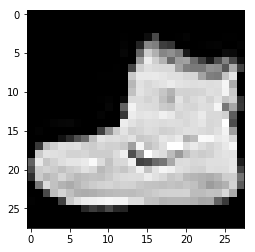

In [6]:
#Printing Image
plt.imshow(train_x[:,0].reshape((28,28)), interpolation='nearest',cmap='gray')
plt.show()

In [7]:
#Importing Necessary Libraries for Transformation
from skimage.transform import rescale
from skimage.transform import rotate
from skimage import exposure
import warnings
warnings.filterwarnings("ignore")

#### Transformation Functions:

In [8]:
def image_with_rotation(image,degree):
    return rotate(image, degree)

In [9]:
def horizontal_flip(image):
    return image[:, ::-1]

In [10]:
def vertical_flip(image):
    return image[::-1, :]

In [11]:
def better_contrast(image):
    v_min, v_max = np.percentile(image, (0.2, 99.8))
    return exposure.rescale_intensity(image, in_range=(v_min, v_max))

Below Augmentation is done sequentially on train data so labels in rotated_image,hori_flip,etc. are retained in the order of training set.

In [12]:
rotated_image=[]
hori_flip=[]
verti_flip=[]
better_cont=[]
for i in range(0,60000):
    image=train_x[:,i].reshape((28,28))
    rotated_image.append(image_with_rotation(image,90))
    hori_flip.append(horizontal_flip(image))
    verti_flip.append(vertical_flip(image))
    better_cont.append(better_contrast(image))

In [13]:
# plt.imshow(np.array(better_cont)[2].reshape((28,28)),interpolation='nearest',cmap='gray')
# plt.show()

In [14]:
#Reshaping in conventional Form
rotated_image=np.array(rotated_image).reshape((60000,-1)).T
hori_flip=np.array(hori_flip).reshape((60000,-1)).T
verti_flip=np.array(verti_flip).reshape((60000,-1)).T
better_cont=np.array(better_cont).reshape((60000,-1)).T

In [15]:
train_x=np.concatenate((train_x,rotated_image),axis=1)
train_x=np.concatenate((train_x,hori_flip),axis=1)
train_x=np.concatenate((train_x,verti_flip),axis=1)
train_x=np.concatenate((train_x,better_cont),axis=1)

In [16]:
train_y_temp=train_y.copy()

In [17]:
train_y=np.concatenate((train_y,train_y_temp),axis=1)
train_y=np.concatenate((train_y,train_y_temp),axis=1)
train_y=np.concatenate((train_y,train_y_temp),axis=1)
train_y=np.concatenate((train_y,train_y_temp),axis=1)

In [22]:
#Normalizing
train_x=train_x/255
test_x=test_x/255

### Part -2
#### Build a CNN network from scratch using tensorflow on transformed data with highest validation accuracy & use that  model for inference.

No Dropout and Mini batch Input.Trained for subset of data from row 30k to 90k.And fed randomly to the network using batch sie of 128.

A 'nan' value for Minibatch Loss came when whole data was used as input.


In [23]:
# Parameters
learning_rate = 0.001
training_iters = 200000
batch_size = 128
display_step = 10

In [46]:
# Network Parameters
n_input = 784  # MNIST data input (img shape: 28*28)
n_classes = 10  # MNIST total classes (0-9 digits)
dropout = 1. # Dropout, probability to keep units

In [47]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)  # dropout (keep probability)

In [48]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [49]:
def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

In [50]:
# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [51]:
# Store layers weight & bias

weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7 * 7 * 64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [52]:
# Construct model
pred = conv_net(x, weights, biases, keep_prob)

In [53]:
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [54]:
# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [55]:
# Initializing the variables
init = tf.initialize_all_variables()

In [56]:
digits = 10 # No. of Classes
m=300000 #Training Instances

Y_new = np.eye(digits)[train_y.astype('int32')]
Y_new = Y_new.T.reshape(digits,m)
Y_test = np.eye(digits)[test_y.astype('int32')]
Y_test = Y_test.T.reshape(digits,10000)

In [57]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [58]:
x_=train_x.T[30000:90000,:]
y_=Y_new.T[30000:90000,:]

In [65]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = next_batch(batch_size,x_,y_)

        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y,
                                       keep_prob: dropout})
        if step % display_step == 0:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y,
                                                              keep_prob: 1.})
            print("Iter " + str(step * batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print("Optimization Finished!")
    print('Testing accuracy:', sess.run(accuracy, feed_dict={x: test_x.T[:1000,:], y:Y_test.T[:1000,:], keep_prob:1.}))
    

Iter 1280, Minibatch Loss= 11336.228516, Training Accuracy= 0.21094
Iter 2560, Minibatch Loss= 8748.800781, Training Accuracy= 0.30469
Iter 3840, Minibatch Loss= 3673.313232, Training Accuracy= 0.43750
Iter 5120, Minibatch Loss= 3067.991699, Training Accuracy= 0.40625
Iter 6400, Minibatch Loss= 3062.059082, Training Accuracy= 0.39844
Iter 7680, Minibatch Loss= 2279.008789, Training Accuracy= 0.44531
Iter 8960, Minibatch Loss= 3268.207520, Training Accuracy= 0.43750
Iter 10240, Minibatch Loss= 3904.333984, Training Accuracy= 0.45312
Iter 11520, Minibatch Loss= 3580.645264, Training Accuracy= 0.33594
Iter 12800, Minibatch Loss= 2624.833740, Training Accuracy= 0.42188
Iter 14080, Minibatch Loss= 3450.515625, Training Accuracy= 0.44531
Iter 15360, Minibatch Loss= 2452.075195, Training Accuracy= 0.46094
Iter 16640, Minibatch Loss= 2297.759033, Training Accuracy= 0.37500
Iter 17920, Minibatch Loss= 3523.083984, Training Accuracy= 0.34375
Iter 19200, Minibatch Loss= 2352.276367, Training Accu

Iter 156160, Minibatch Loss= 1358.777466, Training Accuracy= 0.42969
Iter 157440, Minibatch Loss= 1173.561768, Training Accuracy= 0.49219
Iter 158720, Minibatch Loss= 1000.932678, Training Accuracy= 0.43750
Iter 160000, Minibatch Loss= 745.206238, Training Accuracy= 0.41406
Iter 161280, Minibatch Loss= 701.792603, Training Accuracy= 0.56250
Iter 162560, Minibatch Loss= 1100.536621, Training Accuracy= 0.42969
Iter 163840, Minibatch Loss= 918.338867, Training Accuracy= 0.51562
Iter 165120, Minibatch Loss= 705.562012, Training Accuracy= 0.47656
Iter 166400, Minibatch Loss= 587.995972, Training Accuracy= 0.50781
Iter 167680, Minibatch Loss= 598.442505, Training Accuracy= 0.46875
Iter 168960, Minibatch Loss= 991.612122, Training Accuracy= 0.51562
Iter 170240, Minibatch Loss= 919.793457, Training Accuracy= 0.51562
Iter 171520, Minibatch Loss= 846.554810, Training Accuracy= 0.48438
Iter 172800, Minibatch Loss= 884.922852, Training Accuracy= 0.42188
Iter 174080, Minibatch Loss= 866.818115, Tra

### Part -3
#### Modify the above architecture by using Batch normalization, dropout, ReduceLRonPlateau, Early stopping.


With Dropout =0.5

In [68]:
# Parameters
learning_rate = 0.001
training_iters = 200000
batch_size = 128
display_step = 10

In [69]:
# Network Parameters
n_input = 784  # MNIST data input (img shape: 28*28)
n_classes = 10  # MNIST total classes (0-9 digits)
dropout = 0.50 # Dropout, probability to keep units

In [70]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)  # dropout (keep probability)

In [71]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [72]:
def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

In [73]:
# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [74]:
# Store layers weight & bias

weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7 * 7 * 64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [75]:
# Construct model
pred = conv_net(x, weights, biases, keep_prob)

In [76]:
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [77]:
# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [78]:
# Initializing the variables
init = tf.initialize_all_variables()

In [79]:
digits = 10 # No. of Classes
m=300000 #Training Instances

Y_new = np.eye(digits)[train_y.astype('int32')]
Y_new = Y_new.T.reshape(digits,m)
Y_test = np.eye(digits)[test_y.astype('int32')]
Y_test = Y_test.T.reshape(digits,10000)

In [80]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [81]:
x_=train_x.T[30000:90000,:]
y_=Y_new.T[30000:90000,:]

In [82]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = next_batch(batch_size,x_,y_)

        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y,
                                       keep_prob: dropout})
        if step % display_step == 0:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y,
                                                              keep_prob: 1.})
            print("Iter " + str(step * batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print("Optimization Finished!")
    print('Testing accuracy:', sess.run(accuracy, feed_dict={x: test_x.T[:1000,:], y:Y_test.T[:1000,:], keep_prob:1.}))
    

Iter 1280, Minibatch Loss= 11697.900391, Training Accuracy= 0.22656
Iter 2560, Minibatch Loss= 6787.408691, Training Accuracy= 0.46094
Iter 3840, Minibatch Loss= 6731.474121, Training Accuracy= 0.35938
Iter 5120, Minibatch Loss= 5288.691406, Training Accuracy= 0.33594
Iter 6400, Minibatch Loss= 3211.822998, Training Accuracy= 0.35938
Iter 7680, Minibatch Loss= 3340.376221, Training Accuracy= 0.51562
Iter 8960, Minibatch Loss= 2577.412598, Training Accuracy= 0.45312
Iter 10240, Minibatch Loss= 3992.897217, Training Accuracy= 0.44531
Iter 11520, Minibatch Loss= 1660.057373, Training Accuracy= 0.42188
Iter 12800, Minibatch Loss= 3798.840088, Training Accuracy= 0.32031
Iter 14080, Minibatch Loss= 2429.719971, Training Accuracy= 0.41406
Iter 15360, Minibatch Loss= 2530.681641, Training Accuracy= 0.42969
Iter 16640, Minibatch Loss= 2213.971680, Training Accuracy= 0.45312
Iter 17920, Minibatch Loss= 1223.053467, Training Accuracy= 0.38281
Iter 19200, Minibatch Loss= 1751.330078, Training Accu

Iter 157440, Minibatch Loss= 64.269020, Training Accuracy= 0.46875
Iter 158720, Minibatch Loss= 76.939682, Training Accuracy= 0.38281
Iter 160000, Minibatch Loss= 70.889816, Training Accuracy= 0.48438
Iter 161280, Minibatch Loss= 50.163727, Training Accuracy= 0.49219
Iter 162560, Minibatch Loss= 59.067192, Training Accuracy= 0.52344
Iter 163840, Minibatch Loss= 67.853897, Training Accuracy= 0.40625
Iter 165120, Minibatch Loss= 72.254372, Training Accuracy= 0.43750
Iter 166400, Minibatch Loss= 43.169518, Training Accuracy= 0.40625
Iter 167680, Minibatch Loss= 120.090584, Training Accuracy= 0.42969
Iter 168960, Minibatch Loss= 35.850197, Training Accuracy= 0.39844
Iter 170240, Minibatch Loss= 68.601608, Training Accuracy= 0.45312
Iter 171520, Minibatch Loss= 40.715919, Training Accuracy= 0.42188
Iter 172800, Minibatch Loss= 53.471359, Training Accuracy= 0.38281
Iter 174080, Minibatch Loss= 47.087692, Training Accuracy= 0.45312
Iter 175360, Minibatch Loss= 33.706306, Training Accuracy= 0.